In [2]:
import IPython
import sys

def clean_notebook():
    IPython.display.clear_output(wait=True)
    print("Notebook cleaned.")

# Run the installation commands
!pip install opendatasets
!pip install ultralytics
!pip install pytubefix

# Clean up the notebook
clean_notebook()



Notebook cleaned.


In [1]:

import ultralytics
ultralytics.checks()

Ultralytics 8.3.47 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-80GB MIG 7g.80gb, 81051MiB)
Setup complete ✅ (256 CPUs, 2015.7 GB RAM, 289.8/3519.1 GB disk)


# Yolo 11 with Video files

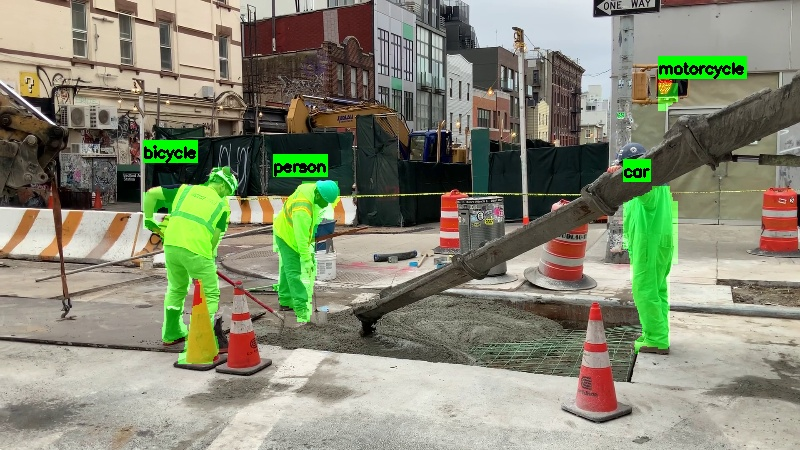

In [ ]:
import cv2
from ultralytics import YOLO
from IPython.display import display, Image, clear_output
import numpy as np

# Set the desired width for resizing frames
set_width = 800

# Load the YOLO model
model = YOLO("yolo11n-seg.pt")

# Class names (ensure these match your model's training dataset, e.g., COCO)
class_names = model.names  # Assuming `model.names` provides the class name mapping

# Initialize video capture (0 for webcam, or provide a video file path)
video_path = ".././Videos/video4.mp4"
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print(f"Error: Could not open video source: {video_path}")
    cap.release()
    raise RuntimeError("Video initialization failed.")

try:
    while True:
        # Read a frame from the video
        ret, frame = cap.read()
        if not ret:
            print("End of video or failed to grab frame.")
            break
        
        # Resize the frame for faster processing
        ratio = set_width / frame.shape[1]
        frame = cv2.resize(frame, (set_width, int(frame.shape[0] * ratio)))

        # Convert BGR frame to RGB for YOLO inference
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Run YOLO inference on the frame
        results = model(rgb_frame, imgsz=640, verbose=False)

        # Draw segmentation masks and labels if results are available
        if len(results) > 0 and hasattr(results[0], 'masks'):
            masks = results[0].masks
            object_count = masks.data.shape[0]  # Number of masks

            # Create a combined mask initialized to zeros
            height, width = frame.shape[:2]

            for i in range(object_count):
                # Extract individual mask as a binary array
                mask_tensor = masks.data[i]  # Extract mask tensor
                mask_array = mask_tensor.cpu().numpy()  # Convert to NumPy array
                mask_array = (mask_array > 0.5).astype(np.uint8) * 255  # Binarize and scale to 255

                # Resize mask to match the frame
                mask_array = cv2.resize(mask_array, (width, height), interpolation=cv2.INTER_NEAREST)

                # Overlay the mask on the frame
                colored_mask = np.zeros_like(frame)
                colored_mask[:, :, 1] = mask_array  # Apply green color for the mask
                frame = cv2.addWeighted(frame, 1, colored_mask, 0.5, 0)

                # Find the contour of the mask to determine where to place the label
                contours, _ = cv2.findContours(mask_array, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                if contours:
                    # Get the largest contour
                    largest_contour = max(contours, key=cv2.contourArea)
                    x, y, w, h = cv2.boundingRect(largest_contour)

                    # Get the class name (assuming `class_names[i]` corresponds to the mask index)
                    class_name = class_names[i] if i < len(class_names) else f"ID {i}"

                    # Create label text
                    label = f"{class_name}"

                    # Calculate the position for the label
                    label_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)[0]
                    label_x = x
                    label_y = y - 10  # Position above the mask bounding box

                    # Ensure the label does not go out of frame
                    label_y = max(label_y, label_size[1] + 5)

                    # Draw a filled rectangle behind the text for better visibility
                    cv2.rectangle(frame, (label_x, label_y - label_size[1] - 5), 
                                  (label_x + label_size[0], label_y + 5), (0, 255, 0), -1)

                    # Put the label text above the mask
                    cv2.putText(frame, label, (label_x, label_y), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)

        # Encode the frame as JPEG
        _, buffer = cv2.imencode('.jpg', frame)
        img_bytes = buffer.tobytes()

        # Display the frame inline in the notebook
        display(Image(data=img_bytes))
        clear_output(wait=True)
finally:
    cap.release()


In [1]:
import cv2
from ultralytics import YOLO
from IPython.display import display, Image, clear_output
import numpy as np

# Set the desired width for resizing frames
set_width = 800

# Load the YOLO model
model = YOLO("yolo11n-seg.pt")

# Class names (ensure these match your model's training dataset, e.g., COCO)
class_names = model.names  # Assuming `model.names` provides the class name mapping

# Initialize video capture (0 for webcam, or provide a video file path)
video_path = ".././Videos/video4.mp4"
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print(f"Error: Could not open video source: {video_path}")
    cap.release()
    raise RuntimeError("Video initialization failed.")

try:
    while True:
        # Read a frame from the video
        ret, frame = cap.read()
        if not ret:
            print("End of video or failed to grab frame.")
            break
        
        # Resize the frame for faster processing
        ratio = set_width / frame.shape[1]
        frame = cv2.resize(frame, (set_width, int(frame.shape[0] * ratio)))

        # Convert BGR frame to RGB for YOLO inference
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Run YOLO inference on the frame
        results = model(rgb_frame, imgsz=640, verbose=False)

        # Create a black screen for segmented objects
        height, width = frame.shape[:2]
        black_screen = np.zeros((height, width, 3), dtype=np.uint8)

        if len(results) > 0 and hasattr(results[0], 'masks'):
            masks = results[0].masks
            object_count = masks.data.shape[0]  # Number of masks

            for i in range(object_count):
                # Extract individual mask as a binary array
                mask_tensor = masks.data[i]  # Extract mask tensor
                mask_array = mask_tensor.cpu().numpy()  # Convert to NumPy array
                mask_array = (mask_array > 0.5).astype(np.uint8) * 255  # Binarize and scale to 255

                # Resize mask to match the frame
                mask_array = cv2.resize(mask_array, (width, height), interpolation=cv2.INTER_NEAREST)

                # Assign a unique color to the mask
                color = (np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255))
                colored_mask = np.zeros_like(black_screen)
                for c in range(3):
                    colored_mask[:, :, c] = mask_array * color[c]

                # Overlay the mask onto the black screen
                black_screen = cv2.addWeighted(black_screen, 1, colored_mask, 0.5, 0)

                # Find the contour of the mask to determine where to place the label
                contours, _ = cv2.findContours(mask_array, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                if contours:
                    # Get the largest contour
                    largest_contour = max(contours, key=cv2.contourArea)
                    x, y, w, h = cv2.boundingRect(largest_contour)

                    # Get the class name (assuming `class_names[i]` corresponds to the mask index)
                    class_name = class_names[i] if i < len(class_names) else f"ID {i}"

                    # Create label text
                    label = f"{class_name}"

                    # Calculate the position for the label
                    label_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)[0]
                    label_x = x
                    label_y = y - 10  # Position above the mask bounding box

                    # Ensure the label does not go out of frame
                    label_y = max(label_y, label_size[1] + 5)

                    # Draw a filled rectangle behind the text for better visibility
                    cv2.rectangle(black_screen, (label_x, label_y - label_size[1] - 5), 
                                  (label_x + label_size[0], label_y + 5), color, -1)

                    # Put the label text above the mask
                    cv2.putText(black_screen, label, (label_x, label_y), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)

        # Encode the frame as JPEG
        _, buffer = cv2.imencode('.jpg', black_screen)
        img_bytes = buffer.tobytes()

        # Display the black screen inline in the notebook
        display(Image(data=img_bytes))
        clear_output(wait=True)
finally:
    cap.release()


End of video or failed to grab frame.
